# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

CSDN - 常見優化器方法總結：

<pre>
SGD (mini-batch)
在單步更新與全局更新的折衷辦法，通常搭配 momentum 穩定收斂方向與結果。
收斂速度較慢。
RMSprop
學習率的調整是根據過去梯度的狀況調整，收斂速度快又不易會出現 learning rate 快速下降的狀況。
Adam
同樣是可以根據過去的梯度自行調整 learning rate，但校正方式考量一、二階矩陣，使其更加平穩。


在實作過程中，建議先使用 Adam 驗證，若要做最終的優化，則再改用 SGD 找到最佳參數。
</pre>

參考連結：



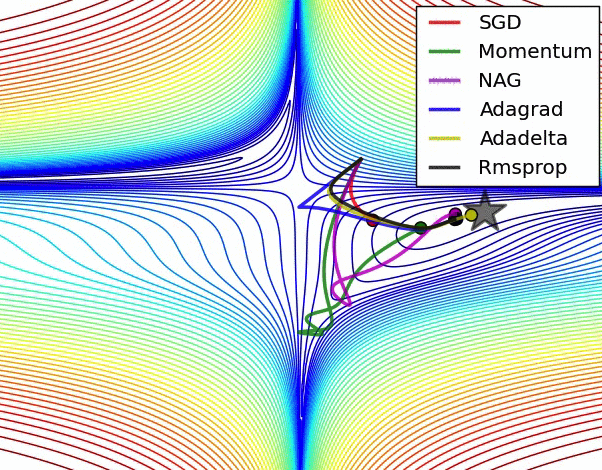

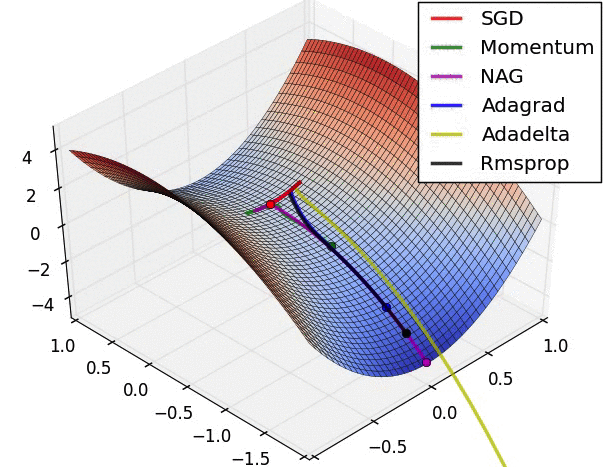

1. http://ruder.io/optimizing-gradient-descent/

2. [CSDN-優化器方法總結](https://blog.csdn.net/u010089444/article/details/76725843)

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if(i == 0):
            hidden_layer = keras.layers.Dense(units = n_units, activation = 'relu', name = "hidden_layer"+str(i+1))(input_layer)
        else:
            hidden_layer = keras.layers.Dense(units = n_units, activation = 'relu', name = "hidden_layer"+str(i+1))(hidden_layer)
    
    output_layer =  keras.layers.Dense(units = output_units, activation = "softmax", name = "output")(hidden_layer)
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])

    return model

In [6]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [512, 256, 128, 64]
MOMENTUM = 0.95


In [7]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""

for mini_size in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Batch_size = %.2f" % (mini_size))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=mini_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-BATCH_SIZE-%s" % str(mini_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Batch_size = 512.00
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updatin

50000/50000 [==============================] - 7s 144us/step - loss: 1.2672 - acc: 0.5547 - val_loss: 1.3910 - val_acc: 0.5030
Experiment with Batch_size = 128.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
___________________________________

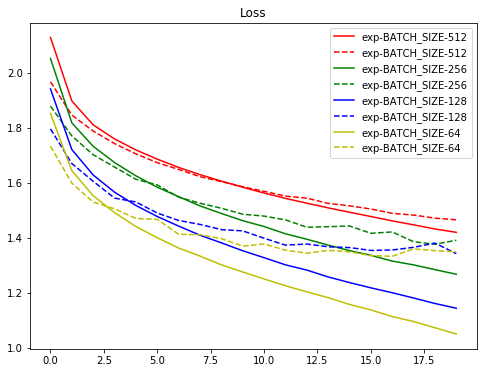

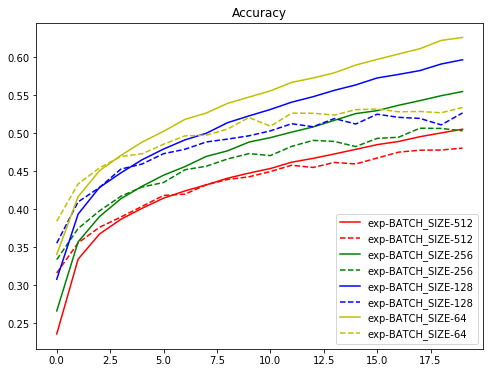

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()